# Aircraft detection using YOLO11

This notebook contains details and a step-by-step guide to build an object detection program locally for aircraft detection. We will use models from YOLO11. This is only for academic and learning purposes, therefore we claim no originality in the methods and techniques used. This notebook is highly inspired from guides given by EJ Technology Consultants and the YOLO11 documentation.

<!-- ## License
This notebook is licensed under the MIT License. See the [LICENSE](LICENSE) file for details. -->

## References
1. EJ Technology Consultants (2024). How to Train YOLO 11 Object Detection Models Locally with NVIDIA. Retrieved from [here](https://www.ejtech.io/learn/train-yolo-models#:~:text=This%20guide%20provides%20step-by-step%20instructions%20for%20training%20a,on%20a%20local%20PC%20using%20an%20NVIDIA%20GPU.)].
2. Ultralytics. (2024). YOLO Documentation. https://docs.ultralytics.com/


## Contents
1. [Step 1: Preliminaries, environment and required packages](#Step-1:-Preliminaries,-environment-and-required-packages)

2. [Step 2: Dataset and Organization](#Step-2:-The-dataset-and-labelings)

3. [Step 3: Setting up labels](#Step-3:-Setting-up-labels)

4. [Step 4: Training configuration](#Step-4:-Training-Configuration)

5. [Step 5: Training the model](#Step-5:-Train-the-model)



## Step 1: Preliminaries, environment and required packages

We start by creating a virtual environment in our project folder in order to install all the required packages. Recall this is made by first navigating to the project directory and execute: 

```sh 
cd "c:\Users\user\project_directory"
```

Next, activate the virtual environment and install the packages using the `requirements.txt` file: 

```sh
.\env\Scripts\activate
pip install -r requirements.txt 
```

When your environment is active, you will see the name of the environment in parentheses at the left of the command line. 


Now, we will install the `ultralytics` library (if not yet installed from the `requirements.txt` file):

In [ ]:
%pip install ultralytics;

Note: you may need to restart the kernel to use updated packages.


Since we will train in our local GPU, we need to use the GPU-enabled version of PyTorch. You can find the command to install it [here](https://pytorch.org/get-started/locally/). 

In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118;

Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.


We can confirm if PyTorch-GPU is correctly installed by running the following lines: 

In [1]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Print the result
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the GPU name
print(f"GPU Name: {torch.cuda.get_device_name(0)}" if cuda_available else "No GPU available.") 

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CUDA available: True
GPU Name: NVIDIA GeForce GTX 1650 with Max-Q Design


## Step 2: The dataset and labelings

Before training we need to preprocess our data. In this notebook we will use the Kaggle's [Airbus Aircraft dataset](https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset) from Airbus High Resolution Satellite Imagery. We can download the dataset using kagglehub. 

Note: We may need to set up our API keys from kaggle. For this visit https://www.kaggle.com/docs/api#authentication. 

First, let us install kagglehub:

In [4]:
%pip install kagglehub;

Note: you may need to restart the kernel to use updated packages.


Now we download the last version of the dataset. 

In [5]:
import kagglehub

# Download latest version
download_path = kagglehub.dataset_download("airbusgeo/airbus-aircrafts-sample-dataset")

print("Path to dataset files:", download_path)

c:\Users\storo\OneDrive - Universidad Nacional de Colombia\Documentos\2025\Machine Learning\Projects\Airbus_Aircraft_Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\storo\.cache\kagglehub\datasets\airbusgeo\airbus-aircrafts-sample-dataset\versions\3


We can then copy the downloaded dataset to our project folder from the `download_path` to a folder named `dataset`

```python
import shutil
import os

shutil.copytree(download_path, os.path.join(os.getcwd(), "dataset"))
```

__Note:__ Of course you can also download manually the dataset from Kaggle and the copy it to your project folder. 

According to the description of the Airbus Aircraft dataset we have the following:

### Imagery for training

The `images` folder contains 103 extract of Pleiades imagery at roughly 50 cm resolution. Each each image is stored as a JPEG file of size 2560 x 2560 pixels (i.e. 1280 meters on ground). 

We will use this set of images to train our model. Before doing so we have to split our image dataset into train and validation sets.

### Annotations (labels)

All aircrafts have been annotated with bounding boxes on the provided imagery. These annotations are provided in the form of closed GeoJSON polygons. A CSV file named `annotations.csv` provides all anotations - one annotation per line with the corresponding filename of the image as `image_id` and the class of the annotation, mainly `Aircraft` or `Truncated_Aircraft` for aircrafts located at the border of the image.

Sometimes the dataset may not have annotations or labels corresponding to the objects we want to detect. In this case one can construct annotations using label tools such as [LabelImg](https://github.com/HumanSignal/labelImg) or [LabelStudio](https://labelstud.io/). It is important to notice that our dataset comes with annotations in the form of closed GeoJSON polygons so we will have to convert them into Yolo annotation format. We will see this in Step 3. 

### Extra imagery

A folder named `extras` contains 6 extra images which are not annotated but could be used to test a model on new - unseen before - images. We will use these images to make predictions once we train the YOLO model. 

## Step 3: Setting up labels

### Understanding our dataset

As mentioned before our dataset comes with annotations in the form of closed GeoJSON polygons. Recall that a GeoJSON polygon has the following format: 

```sh 
{
  "type": "Feature",
  "geometry": 
  {
    "type": "Polygon",
    "coordinates": [
      [
        [x1, y1], [x2, y2], [x3, y3], [x4, y4], [x1, y1]
      ]
    ]
  },
  "properties": 
  {
    "class": "object_name"
  }
}
```
The `annotations.cvs` file has two key columns: image_id and geometry. The image_id column provides unique image identifiers. Since multiple aircrafts of interest can exist within the same image, image_id values may repeat across multiple rows.
The geometry column contains the spatial information of the aircrafts within the corresponding image. Each entry in the geometry column has the polygon coordinates in the format above. This structure means that a single image can have multiple associated geometries, each contained in a different row but linked by the same `image_id`. Let us use the polygon geometries of the first image_id in our dataset to graph the corresponding polygons in the image.

In [2]:
#Load the dataset into a pandas dataframe and print first 19 entries
import pandas
annotations = pandas.read_csv("dataset/annotations.csv")
annotations.head(19)

,id,image_id,geometry,class
0,1,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(135, 522), (245, 522), (245, 600), (135, 600...",Airplane
1,2,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1025, 284), (1125, 284), (1125, 384), (1025,...",Airplane
2,3,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1058, 1503), (1130, 1503), (1130, 1568), (10...",Airplane
3,4,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(813, 1518), (885, 1518), (885, 1604), (813, ...",Airplane
4,5,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(594, 938), (657, 938), (657, 1012), (594, 10...",Airplane
5,6,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(451, 725), (524, 725), (524, 798), (451, 798...",Airplane
6,7,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1543, 1437), (1614, 1437), (1614, 1497), (15...",Airplane
7,8,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1485, 1370), (1561, 1370), (1561, 1437), (14...",Airplane
8,9,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1968, 1624), (2053, 1624), (2053, 1687), (19...",Airplane
9,10,4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg,"[(1659, 1674), (1733, 1674), (1733, 1746), (16...",Airplane


As you can see, the first 18 rows have the same image_id: `4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg`. Let us first observe this image. 

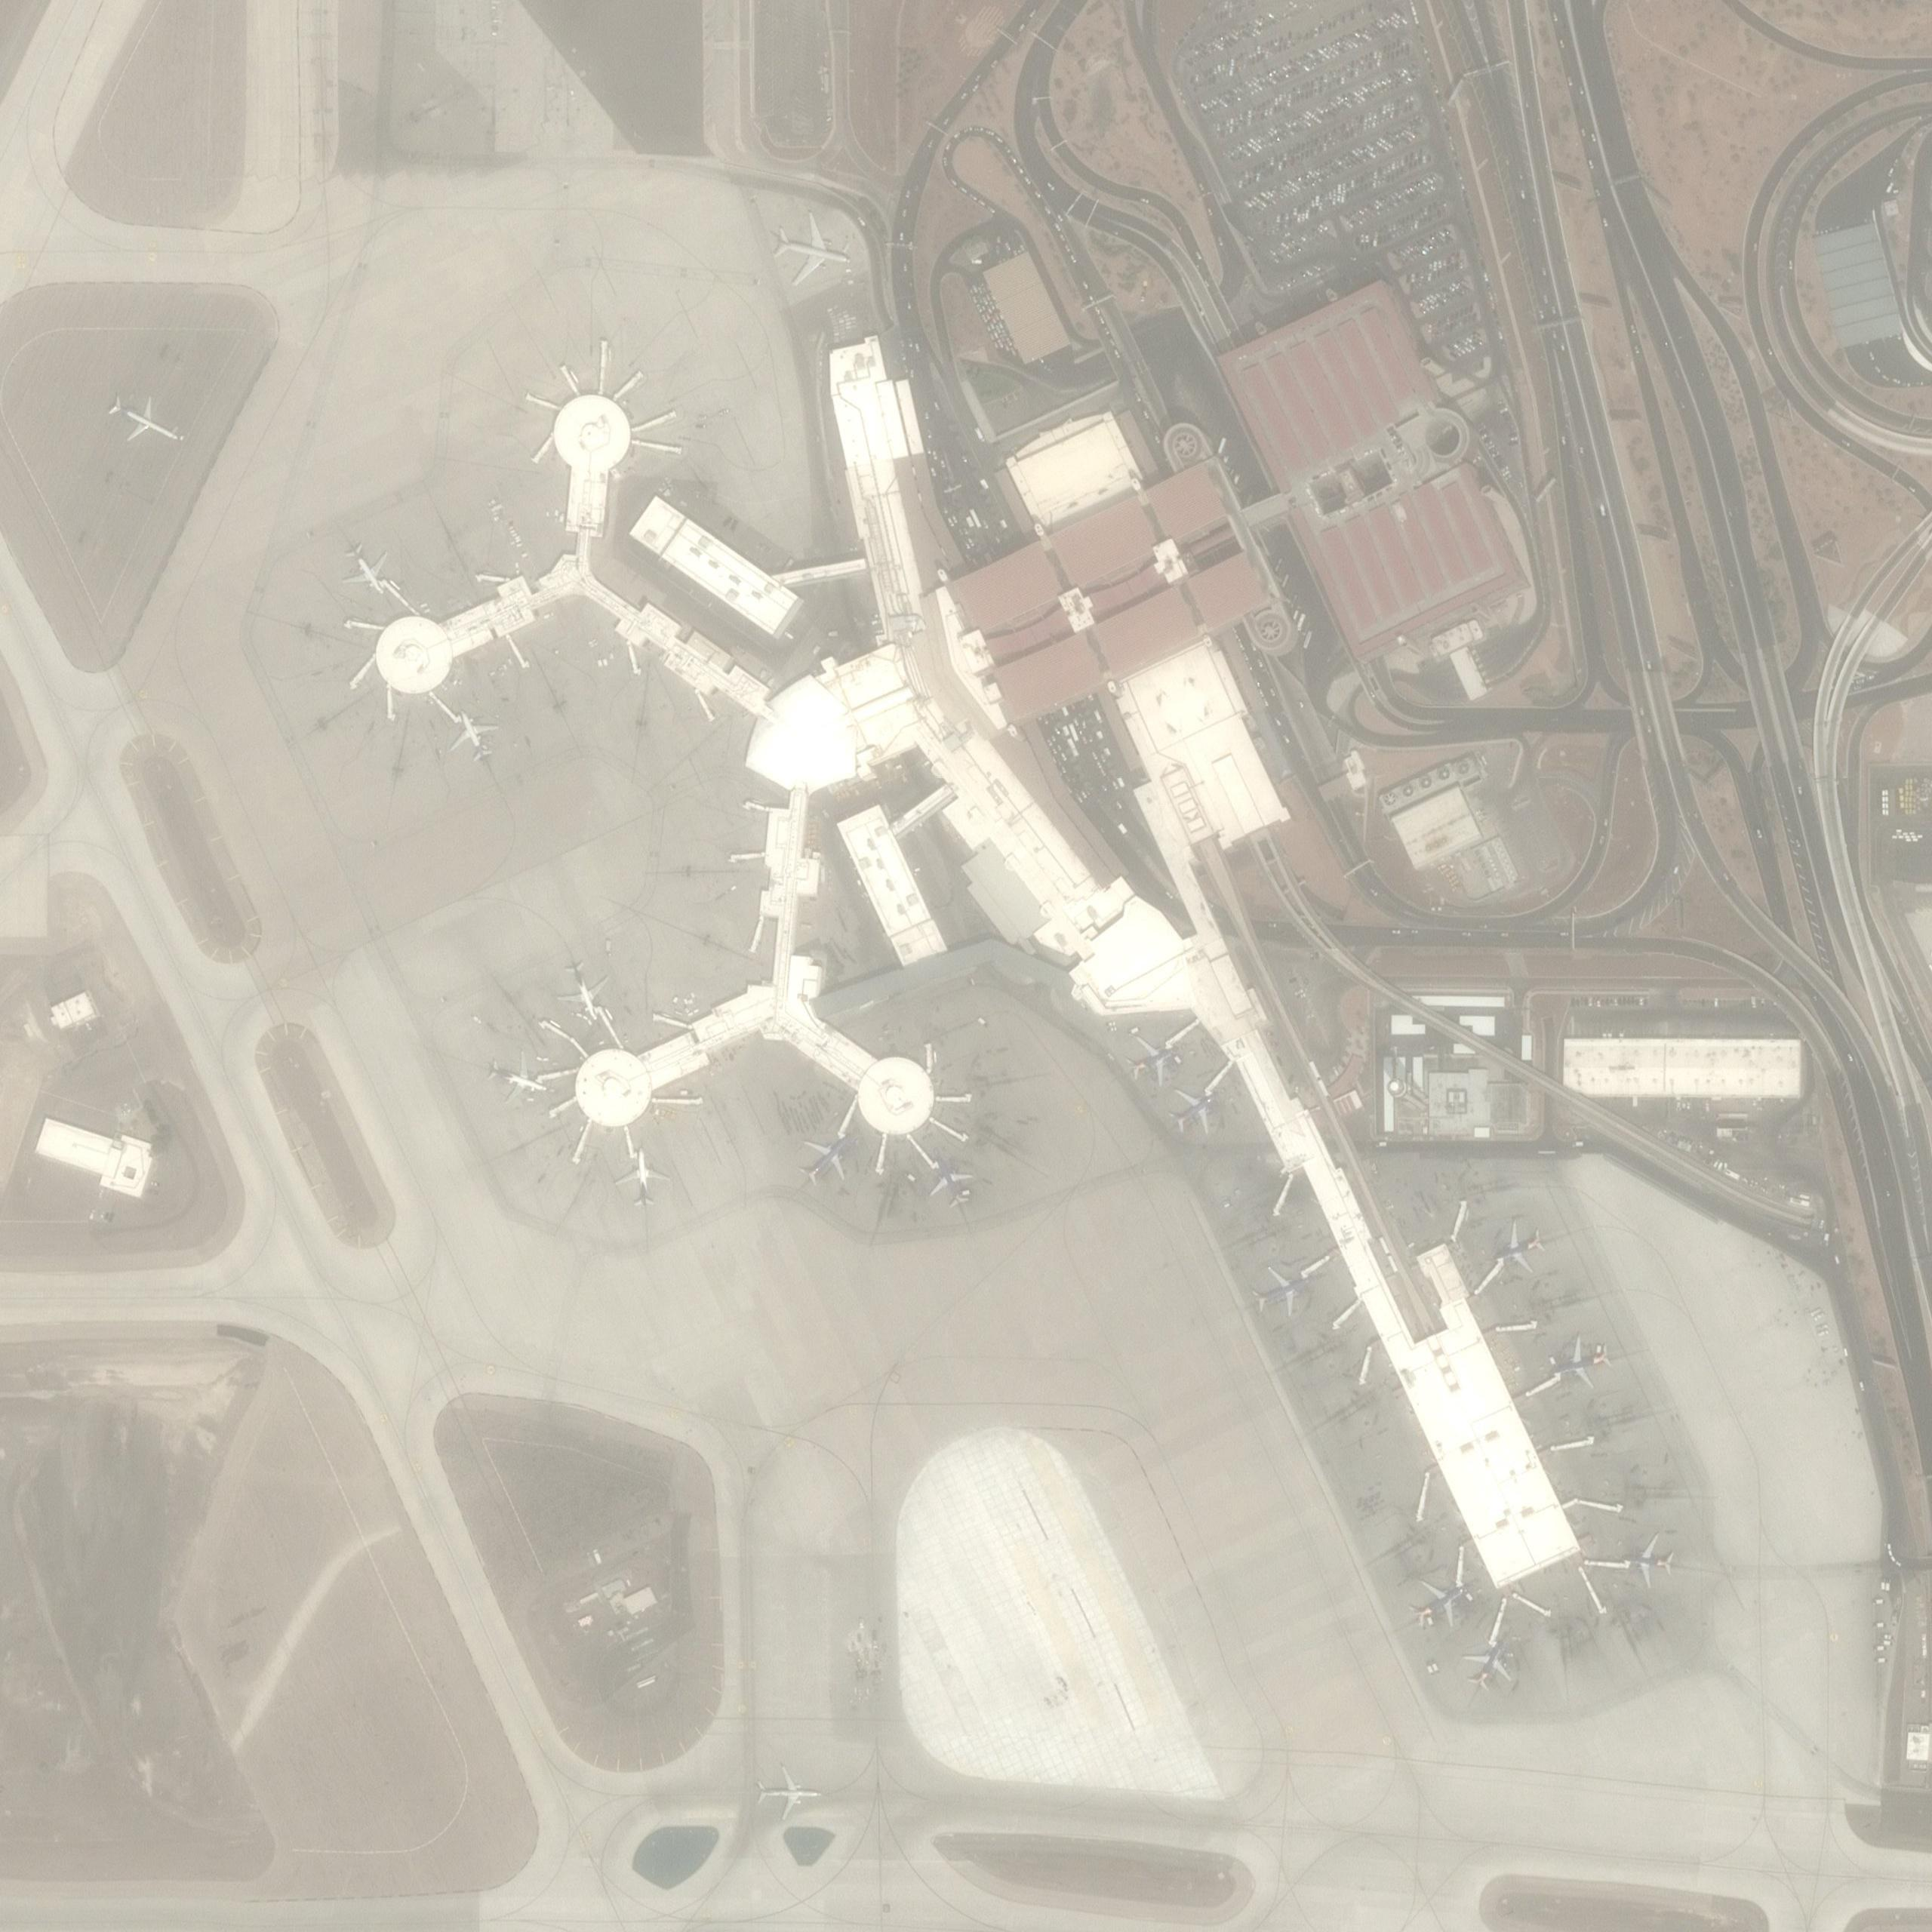

In [3]:
from IPython.display import Image, display

pic_1_path = "dataset/images/4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg"
pic_1_id = "4f833867-273e-4d73-8bc3-cb2d9ceb54ef.jpg"
pic_1 = filename=(pic_1_path) 
display(Image(pic_1))

The image above includes some fog and in a very naive approach we can indeed count 18 aircrafts. Let us extract the aircraft geometries associated to this image. We will refer to the image above as `pic_1`.  

In [4]:
import ast

# Group annotations by image_id and collect geometries
grouped_geometries = annotations.groupby("image_id")["geometry"]

# Apply the conversion function to parse string geometries into actual objects. Recall that the geometries are stored as strings in the CSV file.
all_geometries = grouped_geometries.apply(lambda x: [ast.literal_eval(geom) for geom in x])

# Extract geometries for our specific image
pic_1_geometries = all_geometries[pic_1_id]
pic_1_geometries


[[(135, 522), (245, 522), (245, 600), (135, 600), (135, 522)],
 [(1025, 284), (1125, 284), (1125, 384), (1025, 384), (1025, 284)],
 [(1058, 1503), (1130, 1503), (1130, 1568), (1058, 1568), (1058, 1503)],
 [(813, 1518), (885, 1518), (885, 1604), (813, 1604), (813, 1518)],
 [(594, 938), (657, 938), (657, 1012), (594, 1012), (594, 938)],
 [(451, 725), (524, 725), (524, 798), (451, 798), (451, 725)],
 [(1543, 1437), (1614, 1437), (1614, 1497), (1543, 1497), (1543, 1437)],
 [(1485, 1370), (1561, 1370), (1561, 1437), (1485, 1437), (1485, 1370)],
 [(1968, 1624), (2053, 1624), (2053, 1687), (1968, 1687), (1968, 1624)],
 [(1659, 1674), (1733, 1674), (1733, 1746), (1659, 1746), (1659, 1674)],
 [(1865, 2091), (1951, 2091), (1951, 2165), (1865, 2165), (1865, 2091)],
 [(2052, 1772), (2135, 1772), (2135, 1834), (2052, 1834), (2052, 1772)],
 [(2146, 2031), (2225, 2031), (2225, 2102), (2146, 2102), (2146, 2031)],
 [(1006, 2345), (1088, 2345), (1088, 2412), (1006, 2412), (1006, 2345)],
 [(1931, 2163), 

Now we can plot each of the polygons that enclose the aircrafts:

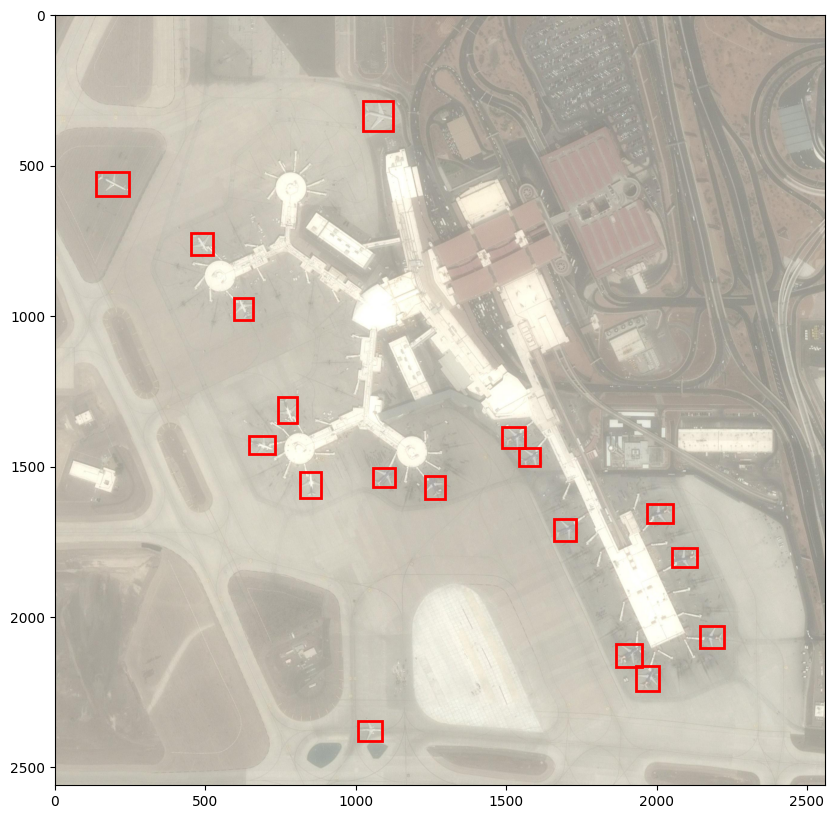

In [5]:
import matplotlib.pyplot as plt
from shapely.geometry import shape
from matplotlib.patches import Polygon
from PIL import Image as PILImage

# Reload pic_1 with PIL
pic_1 = PILImage.open(pic_1_path)

# Create a plot 
fig, ax = plt.subplots(1, figsize=(10,10))

# Display the image
ax.imshow(pic_1) 

# Plot each polygon
for geom in pic_1_geometries:
    patch = Polygon(geom, closed=True, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(patch)

# Show the plot
plt.show()


### GeoJSON to YOLO11 annotations

As we remarked before, in order to train our model we will transform the GeoJSON annotations to the standard YOLO annotation format. This latter consist of the following:

1. Text files (.txt) for each image. 
2. One line per object in each text file.
3. Each line follows this structure: class_id x_center y_center width height.

Where:

- class_id is an integer representing the object class (starting from 0). For the annotations we were given, we will only have two different class id's: 0 for `Airplane` and 1 for `Truncated_airplane`.
- x_center, y_center are the normalized coordinates (0-1) of the bounding box center.
- width, height are the normalized dimensions (0-1) of the bounding box.

We can then write a python script to generate the YOLO annotations from our GeoJSON annotations contained in `annotations.csv`. Since we will also need an specific folder structure for the data we will work on the script later.

### Structuring the dataset

We are almost ready to start training the YOLO model. Ultralytics requires a particular folder structure to store the training data. The root folder is named "data" and inside it contains two main folders for the training and validation data. The folder structure is given as follows: 

```
data/
│── train/
│   ├── images/
│       ├── img_01.jpg
│   ├── labels/
│       ├── img_01.txt
│ 
│── validation/
│   ├── images/
│       ├── img_02.jpg
│   ├── labels/
│       ├── img_02.txt
│── classes.txt

```

As a consequence we have to create a script to generate the YOLO annotations from our `annotations.csv` file and additionally we have to store the data and the created annotations as in the structure above. We will then write a python script that will output the root folder "data" with the required folder structure and at the same time it will create the YOLO annotations we want. This script is under the name `Geojson_to_YOLO.py`

In [10]:
from Geojson_to_YOLO import YOLOConverter

# Create an instance of YOLOConverter
converter = YOLOConverter(
    image_width=2560,  # Replace with your actual image width
    image_height=2560, # Replace with your actual image height
    output_dir="data"  # This will create the structure shown in your diagram
)

# Convert annotations and organize dataset
converter.convert_csv_to_yolo(
    csv_file="dataset/annotations.csv", #path to the annotations file
    images_dir="dataset/images/", #path to the images directory
    train_split=0.8  # 80% training, 20% validation
)

Class mapping complete! Starting dataset organization...
Dataset organization complete! Check 'data' directory for the organized dataset.


We can now check that we have a directory called `data` in which we have stored the train and validation sets in the required manner. 

## Step 4: Training Configuration

Before training we have to create the configuration YAML file. An example of such file can be found in ultralytics documentation (see [here](https://docs.ultralytics.com/datasets/detect/objects365/#dataset-yaml)). For this, we can use our prefered text editor and add a new `.yaml` file with the following contents: 

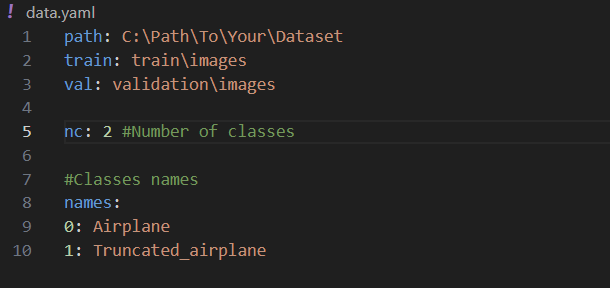
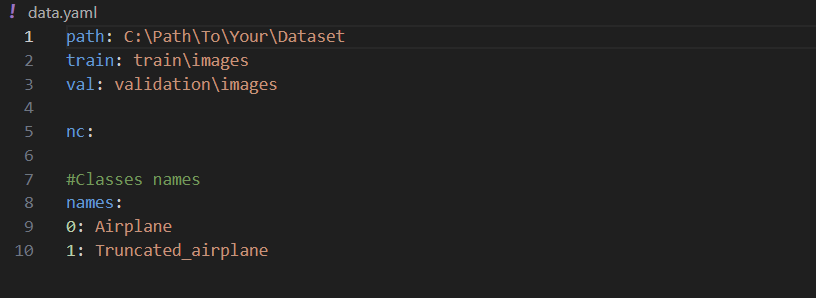

Notice that in path we want to write the path to the `data` folder we build in the last step. Make sure you do not let spaces as in lines 4 and 6, otherwise we will have some error.  

## Step 5: Train the model

There are several YOLO models you can use. Information about metrics can be found in [Ultralytics website](https://docs.ultralytics.com/models/yolo11/#overview). We will use the YOLO11 model. 

In [4]:
from ultralytics import YOLO

#Load the pretrained model from the Ultralytics repository
model = YOLO("yolo11n.pt", task="detect")

#Train the model on our dataset
results = model.train(
    data= "data.yaml", 
    epochs=60, 
    device="cuda")

# Evaluate the model's performance on the validation set
results = model.val()


Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 with Max-Q Design, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning C:\Users\storo\OneDrive - Universidad Nacional de Colombia\Documentos\2025\Machine Learning\Projects\Airbus_Aircraft_Detection\data\train\labels.cache... 82 images, 0 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]
val: Scanning C:\Users\storo\OneDrive - Universidad Nacional de Colombia\Documentos\2025\Machine Learning\Projects\Airbus_Aircraft_Detection\data\validation\labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      4.65G       3.13      4.004      1.675        118        640: 100%|██████████| 6/6 [00:26<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]

                   all         21        807    0.00319     0.0121    0.00164   0.000753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      4.46G      2.337      3.658      1.294         46        640: 100%|██████████| 6/6 [00:21<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]

                   all         21        807    0.00238    0.00763     0.0026    0.00103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      4.89G      1.859      3.126      1.044         83        640: 100%|██████████| 6/6 [00:26<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

                   all         21        807      0.013      0.136     0.0154    0.00647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60       4.5G      1.676       2.67      1.018         35        640: 100%|██████████| 6/6 [00:23<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.21s/it]

                   all         21        807     0.0257      0.213     0.0574     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      4.46G      1.617      2.085     0.9663         47        640: 100%|██████████| 6/6 [00:24<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]

                   all         21        807     0.0534      0.331      0.125     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      4.32G       1.66      1.819     0.9426        154        640: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]

                   all         21        807     0.0822      0.354      0.248      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      4.46G      1.639      1.427     0.9563        120        640: 100%|██████████| 6/6 [00:15<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.39s/it]

                   all         21        807     0.0691       0.34        0.2     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      5.02G      1.597      1.226     0.9509         91        640: 100%|██████████| 6/6 [00:29<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.40s/it]

                   all         21        807     0.0605      0.425      0.211     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      4.47G      1.568      1.214     0.9587         75        640: 100%|██████████| 6/6 [00:29<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]

                   all         21        807     0.0637      0.513      0.337      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      4.89G       1.43      1.012     0.9608         50        640: 100%|██████████| 6/6 [00:24<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:11<00:00, 11.90s/it]

                   all         21        807      0.916       0.34       0.39      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      4.57G      1.376     0.9834     0.9581         40        640: 100%|██████████| 6/6 [00:23<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.49s/it]

                   all         21        807      0.984      0.181      0.403      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      4.76G      1.466     0.9468     0.9348        104        640: 100%|██████████| 6/6 [00:29<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

                   all         21        807      0.956      0.305      0.403      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      4.31G      1.534      1.025     0.9505         58        640: 100%|██████████| 6/6 [00:23<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]

                   all         21        807      0.976      0.326      0.418      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      4.45G      1.453      1.081     0.9486         41        640: 100%|██████████| 6/6 [00:24<00:00,  4.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.43s/it]

                   all         21        807       0.96      0.328      0.409      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      4.65G      1.323     0.9164     0.9033         58        640: 100%|██████████| 6/6 [00:20<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<00:00,  8.02s/it]

                   all         21        807      0.963      0.358      0.422       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      4.72G      1.314     0.9197     0.9297         41        640: 100%|██████████| 6/6 [00:19<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.77s/it]

                   all         21        807       0.96       0.39       0.43       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      4.65G      1.391     0.8918     0.9298         91        640: 100%|██████████| 6/6 [00:22<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]

                   all         21        807      0.939      0.383      0.419      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      4.49G      1.285     0.8733      0.926         30        640: 100%|██████████| 6/6 [00:25<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]

                   all         21        807      0.961      0.408      0.437      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      4.67G      1.354     0.8833     0.9353         40        640: 100%|██████████| 6/6 [00:25<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]

                   all         21        807      0.955      0.405      0.437      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60       4.8G      1.319     0.8656     0.9201        139        640: 100%|██████████| 6/6 [00:23<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]

                   all         21        807      0.936      0.395      0.429      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      4.62G      1.352     0.8161     0.9225         61        640: 100%|██████████| 6/6 [00:13<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

                   all         21        807      0.952        0.4      0.438      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      4.47G       1.23     0.7991     0.9138         72        640: 100%|██████████| 6/6 [00:23<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]

                   all         21        807      0.961      0.408      0.465      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      4.65G      1.341      0.875     0.9303         31        640: 100%|██████████| 6/6 [00:17<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.48s/it]

                   all         21        807      0.962      0.408      0.487      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      4.91G      1.248     0.7903     0.9117         34        640: 100%|██████████| 6/6 [00:17<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.95s/it]

                   all         21        807      0.964      0.415      0.541      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      4.55G      1.308     0.8268     0.9094         42        640: 100%|██████████| 6/6 [00:25<00:00,  4.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]

                   all         21        807      0.962      0.413      0.513      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      4.46G      1.436      1.014     0.9453         22        640: 100%|██████████| 6/6 [00:23<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]

                   all         21        807      0.956       0.41      0.529       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      4.48G      1.326     0.7926     0.9175        134        640: 100%|██████████| 6/6 [00:17<00:00,  2.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.28s/it]

                   all         21        807      0.961       0.41      0.568      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      4.37G      1.197      0.777     0.9125         55        640: 100%|██████████| 6/6 [00:17<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

                   all         21        807      0.969       0.42      0.522       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      4.96G      1.271      0.779     0.8932         95        640: 100%|██████████| 6/6 [00:21<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]

                   all         21        807      0.971      0.419      0.524      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      4.48G      1.217     0.8531     0.9119         23        640: 100%|██████████| 6/6 [00:21<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.00s/it]

                   all         21        807      0.969       0.42      0.608      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      4.55G      1.245     0.7428     0.8884         86        640: 100%|██████████| 6/6 [00:21<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]

                   all         21        807      0.973      0.417      0.651      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      4.72G      1.324     0.7587     0.9122         67        640: 100%|██████████| 6/6 [00:19<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]

                   all         21        807      0.729      0.549      0.672      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60       4.7G      1.242     0.7641      0.914         84        640: 100%|██████████| 6/6 [00:19<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]

                   all         21        807        0.7      0.558      0.669      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      4.63G      1.318     0.7405     0.9053        118        640: 100%|██████████| 6/6 [00:17<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]

                   all         21        807      0.727      0.543      0.648      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      4.32G      1.246     0.7228     0.9104         50        640: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]

                   all         21        807      0.713      0.573      0.668      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      5.13G      1.226     0.7287     0.8967         78        640: 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.51s/it]

                   all         21        807      0.541      0.568      0.626      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60       4.4G      1.287     0.7539     0.8979         74        640: 100%|██████████| 6/6 [00:16<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]

                   all         21        807      0.579      0.582      0.635      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      4.38G      1.207     0.7195     0.8905         88        640: 100%|██████████| 6/6 [00:15<00:00,  2.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]

                   all         21        807      0.721      0.598      0.697      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      4.41G      1.219     0.6888      0.902         55        640: 100%|██████████| 6/6 [00:15<00:00,  2.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]

                   all         21        807      0.674      0.596      0.699       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      4.79G      1.215     0.7151     0.8921         66        640: 100%|██████████| 6/6 [00:15<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]

                   all         21        807      0.788      0.594      0.707      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      4.92G      1.166     0.6988     0.8912         53        640: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]

                   all         21        807      0.644      0.711      0.714      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      4.55G      1.257     0.7252     0.8894        194        640: 100%|██████████| 6/6 [00:18<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]

                   all         21        807      0.687      0.739       0.73      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      4.35G      1.309     0.7349     0.8928        123        640: 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]

                   all         21        807      0.852      0.614      0.729      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      4.53G      1.163     0.6666     0.8823         96        640: 100%|██████████| 6/6 [00:20<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]

                   all         21        807       0.86      0.615      0.727      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      4.46G      1.128     0.6639       0.89         43        640: 100%|██████████| 6/6 [00:19<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]

                   all         21        807      0.724      0.666      0.721      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      4.63G      1.149     0.6667      0.885         49        640: 100%|██████████| 6/6 [00:19<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]

                   all         21        807      0.807      0.641       0.72      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      4.41G       1.15     0.7597     0.8775         42        640: 100%|██████████| 6/6 [00:17<00:00,  3.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.01s/it]

                   all         21        807      0.824      0.684      0.724      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      4.66G       1.17      0.667     0.8979         52        640: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]

                   all         21        807      0.793      0.689      0.721      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      4.25G      1.202     0.6744     0.8783         72        640: 100%|██████████| 6/6 [00:22<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]

                   all         21        807      0.764      0.708      0.721      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60       4.6G      1.167     0.6667     0.8747        154        640: 100%|██████████| 6/6 [00:18<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]

                   all         21        807      0.907      0.589       0.72      0.453


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      4.22G      1.134     0.6515     0.8988         51        640: 100%|██████████| 6/6 [00:10<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]

                   all         21        807      0.907      0.588      0.722       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      4.29G      1.171     0.6849     0.8951         53        640: 100%|██████████| 6/6 [00:12<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.15s/it]

                   all         21        807      0.902       0.59      0.727      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      4.26G      1.111     0.6346     0.8857         68        640: 100%|██████████| 6/6 [00:12<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.10s/it]

                   all         21        807      0.902       0.59      0.731      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      4.41G      1.133      0.667     0.8787         57        640: 100%|██████████| 6/6 [00:18<00:00,  3.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.48s/it]

                   all         21        807      0.904      0.608      0.739      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      4.34G      1.155     0.6937     0.8781         57        640: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.05s/it]

                   all         21        807      0.903      0.605       0.74      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      4.18G      1.121     0.6931     0.8911         30        640: 100%|██████████| 6/6 [00:19<00:00,  3.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]

                   all         21        807      0.891      0.592      0.703      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      4.24G       1.09     0.6207     0.8708         61        640: 100%|██████████| 6/6 [00:18<00:00,  3.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.52s/it]

                   all         21        807      0.887      0.593        0.7      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      4.14G      1.103     0.6196     0.8858         45        640: 100%|██████████| 6/6 [00:14<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]

                   all         21        807      0.891      0.592      0.709      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      4.12G      1.098     0.6205     0.8905         74        640: 100%|██████████| 6/6 [00:18<00:00,  3.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]

                   all         21        807      0.897      0.592      0.718      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      4.18G      1.112     0.6427      0.872         62        640: 100%|██████████| 6/6 [00:14<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]

                   all         21        807      0.896      0.608      0.734      0.477



60 epochs completed in 0.446 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 5.5MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 with Max-Q Design, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


                   all         21        807      0.896      0.608      0.734      0.477
              Airplane         21        786      0.909      0.855      0.876       0.62
    Truncated_airplane          9         21      0.883      0.362      0.593      0.333
Speed: 3.0ms preprocess, 11.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\train3
Ultralytics 8.3.94  Python-3.13.2 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650 with Max-Q Design, 4096MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Users\storo\OneDrive - Universidad Nacional de Colombia\Documentos\2025\Machine Learning\Projects\Airbus_Aircraft_Detection\data\validation\labels.cache... 21 images, 0 backgrounds, 0 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:11<00:00,  5.86s/it]


                   all         21        807      0.896      0.608      0.734      0.477
              Airplane         21        786      0.909      0.855      0.876       0.62
    Truncated_airplane          9         21      0.883      0.362      0.593      0.333
Speed: 5.7ms preprocess, 13.6ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs\detect\train32


If everything worked out well, you should have a folder in the working directory called `runs`. Inside we have folders containing the weights obtained form training. We will use these weights to make predictions.


0: 640x640 21 Airplanes, 67.5ms
Speed: 8.7ms preprocess, 67.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


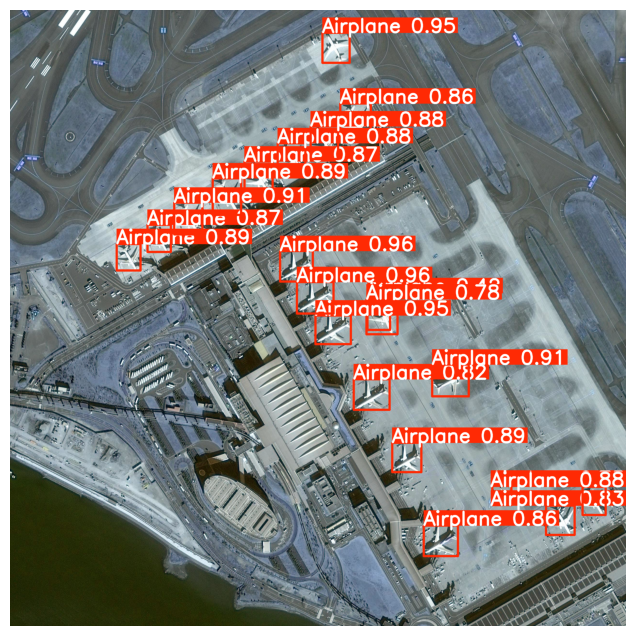

In [6]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

def show_predictions(image_pred_dir, img):
    """
    Display image with predictions using PIL and matplotlib
    Args:
        image_pred_dir: Path to the image directory for predictions
    """
    image_pred_path = Path(image_pred_dir)
    image = Image.open(image_pred_path / img)
    
    # Load model with the best weights from training
    model = YOLO('runs/detect/train3/weights/best.pt')
    
    # Run inference on a single image
    result = model(image)[0]  
    
    # Plot the image with predictions using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(result.plot())  # result.plot() returns a numpy array with the predictions drawn
    plt.axis('off')  # Hide axes
    plt.show()  # Display to screen        

image_pred_dir = "dataset/extras/"
show_predictions(image_pred_dir, "65825eef-f8a1-41b3-ac87-4a0a7d482a0e.jpg")